In [1]:
import torch
import matplotlib.pyplot as plt
import math

from renderer import project_gaussians, rasterize_gaussians
from utils import ellipse_ndim

from matplotlib.patches import Polygon

import numpy as np

### Data

In [2]:
mu = torch.tensor([
    [0., 0., 10.],
])

scale = torch.tensor([
    [1., 0.1, 1.],
])

quat = torch.randn((1, 4))

col = torch.tensor([
    [1, 0, 0],
])

opc = torch.tensor([
    1,
])


### Projection

In [3]:
# Output Image Width and Height
W = 1920
H = 1080 

In [4]:
fov_x = math.pi / 2.0 # Angle of the camera frustum 90°
focal = 0.5 * float(W) / math.tan(0.5 * fov_x) # Distance to Image Plane

In [5]:
(
    mu_,
    cov_,
    z
) = project_gaussians(
    means3d=mu,
    scales=scale,
    quats=quat,
    viewmat=torch.eye(4),
    fx=focal,
    fy=focal,
    cx=W/2,
    cy=H/2,
    img_height=H,
    img_width=W
)

(0.0, 1080.0)

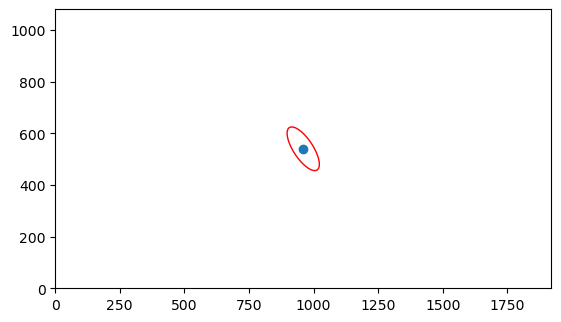

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ellipse_ndim(mu_, cov_, ax, edgecolor='red')
ax.scatter(mu_[0,0], mu_[0,1])

ax.set_aspect('equal', adjustable='box')
ax.set_xlim([0,W])
ax.set_ylim([0,H])

In [7]:
print(mu_)

tensor([[960., 540.]])


##################################

### Rendering

In [8]:
out_img = rasterize_gaussians(
    xys=mu_,
    depths=z,
    covs=cov_,
    conics=None,
    num_tiles_hit=None,
    colors=col,
    opacity=opc,
    img_height=H,
    img_width=W,
    block_width=None,
    background=None,
    return_alpha=None
)

100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


(0.0, 1080.0)

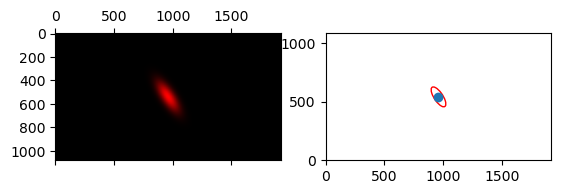

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(out_img)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.scatter(mu_[0,0], mu_[0,1])
# ax2.scatter(mu_[1,0], mu_[1,1])
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([0,W])
ax2.set_ylim([0,H])

### Tiling (SAT)

$\Sigma_2 = \begin{bmatrix} a & b \\ b & d \end{bmatrix}$

Eigenvalues: \
    $\lambda_1 = \frac{a + d + \sqrt{(a-d)^2 + 4b^2}}{2}$ \
    $\lambda_2 = \frac{a + d - \sqrt{(a-d)^2 + 4b^2}}{2}$

In [10]:
def get_eigenvalues(cov):
    a = cov[:,0,0]; b = cov[:,0,1]; d = cov[:,1,1]

    A = torch.sqrt(a*a - 2*a*d + 4*b**2 + d*d)
    B = a + d

    return 0.5 * (A + B), 0.5 * (-A + B)

$r_1 = 3\sqrt{\lambda_1}$ \
$r_2 = 3\sqrt{\lambda_2}$

In [11]:
def get_radii(cov):
    eigs = get_eigenvalues(cov)
    l1, l2 = eigs[0], eigs[1]
    return 1 * torch.sqrt(l1), 1 * torch.sqrt(l2) # TODO: change to 3 * sigma

In [12]:
def get_orientation(cov):
    a = cov[:,0,0]; b = cov[:,0,1]; c = cov[:,1,1]
    eigs = get_eigenvalues(cov)
    l1 = eigs[0]

    if b == 0:
        if a >= c:
            return torch.tensor(0.)
        else:
            return torch.tensor(torch.pi/2)
    else:
        return torch.atan2(l1 - a, b)


In [13]:
torch.arctan(torch.tensor([1]))

tensor([0.7854])

In [14]:
math.atan(1)

0.7853981633974483

In [15]:
get_eigenvalues(cov_)[0]/cov_[0,0,1]

tensor([-2.5590])

In [16]:
get_orientation(cov_)

tensor([2.1526])

In [17]:
def get_rotation(theta):
    cos = torch.cos(theta)
    sin = torch.sin(theta)

    return torch.tensor([
        [cos, -sin],
        [sin,  cos]
    ])

In [18]:
def get_box(mu, cov):
    N = len(mu)

    r1, r2 = get_radii(cov)

    B = torch.empty((N, 4, 2))

    B[:,0,0] = mu[:,0] - r1; B[:,0,1] = mu[:,1] + r2
    B[:,1,0] = mu[:,0] + r1; B[:,1,1] = mu[:,1] + r2
    B[:,3,0] = mu[:,0] - r1; B[:,2,1] = mu[:,1] - r2
    B[:,2,0] = mu[:,0] + r1; B[:,3,1] = mu[:,1] - r2
    
    return B

In [19]:
# cov_ = torch.tensor([[
#     [50_000., 0.],
#     [0., 200_000.],
# ]])

In [20]:
theta = get_orientation(cov_)
# theta = torch.tensor(torch.pi/4)
rot = get_rotation(theta)
theta

tensor([2.1526])

In [21]:
box = get_box(mu_, cov_)
box_mean = box.mean(dim=1)
rot_box = (rot @ (box - box_mean).permute((0,2,1))).permute((0,2,1)) + box_mean

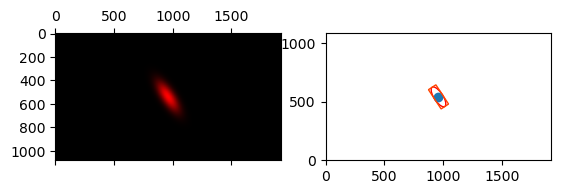

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(out_img)

ellipse_ndim(mu_, cov_, ax2, edgecolor='red')
ax2.scatter(mu_[0,0], mu_[0,1])
# ax2.scatter(mu_[1,0], mu_[1,1])
ax2.set_aspect('equal', adjustable='box')

ax2.set_xlim([0,W])
ax2.set_ylim([0,H])

p = Polygon(rot_box[0], fc='none', ec='orangered')

ax2.add_patch(p)

In [23]:
get_orientation(cov_)

tensor([2.1526])

### Tiling